In [4]:
# load the modules and functions

from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset
from functions.map_plotting import southern_ocean_map

import functions.plot_params

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
from glob import glob
import cmocean.cm as cmo
import matplotlib.ticker as mticker

from cartopy.util import add_cyclic_point

from tqdm.notebook import tqdm

import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
# Figure 1a

In [6]:
# read in the cyclone data

cyclones = xr.open_mfdataset('../../data/storms_lodise/ec_centers_1981_2020.nc')

ds_cyclones_summer = cyclones.sel(TIME=cyclones.TIME.dt.season=="DJF")

In [7]:
# create histogram of storm track density during the summer months

storms_hist, x_hist, y_hist, img1 = plt.hist2d(ds_cyclones_summer.LONGITUDE, ds_cyclones_summer.LATITUDE, bins=(180, 45), cmap='afmhot_r')

plt.close()

In [8]:
# load the ACC fronts and sea ice edge locations 

import pandas as pd

sie = pd.read_csv('../../data/seaice/sie.csv').to_xarray().drop('Unnamed: 0')
fronts = pd.read_csv('../../data/fronts/ACCfronts.csv').to_xarray().drop('Unnamed: 0')

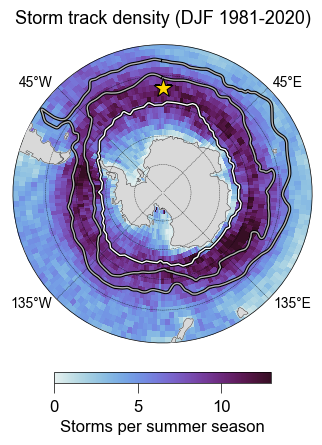

In [9]:
# histogram of the storm track density

fig = plt.figure(figsize=(4, 5))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img=ax.pcolormesh(x_hist[1:], y_hist[1:], storms_hist.T / 40, cmap=cmo.dense, transform=ccrs.PlateCarree(), vmin=0, vmax=13)

ax.set_title('Storm track density (DJF 1981-2020)', pad=15, fontsize=13)

cb = plt.colorbar(mappable=img, orientation='horizontal', shrink=0.7, pad=0.075)

cb.set_label('Storms per summer season')

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

ax.scatter(0, -54, s=200, marker='*', c='gold', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())

plt.savefig('../../figs/figure_1a.png', dpi=500)

In [10]:
# Figure 1b - mean of the summer median interstorm period 1981-2022

In [11]:
# load the storm and interstorm dataset

ds_storms = xr.open_dataset('/Volumes/LaCie/Work/data/era5/era5_storm_interstorm_periods_1981_2023_DJF.nc')

In [12]:
# nan grid cells where there is missing data in some or all of the years

interstorm_per_mean_noice = ds_storms.interstorm_period.fillna(np.nan).mean(dim='time')

for i, lon in enumerate(interstorm_per_mean_noice.longitude.values):

    idx = np.argmin(np.abs(lon-sie['si_lon'].data))

    idx_to_nan = interstorm_per_mean_noice.latitude < sie['si_lat'][idx]

    interstorm_per_mean_noice[idx_to_nan,i] = np.NaN
    

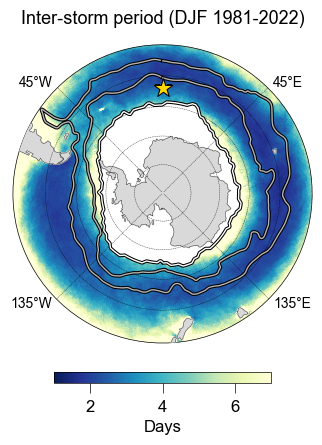

In [13]:
fig = plt.figure(figsize=(4, 5))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

img=ax.pcolormesh(ds_storms.longitude, ds_storms.latitude, interstorm_per_mean_noice, transform=ccrs.PlateCarree(), vmin=1, vmax=7, cmap='YlGnBu_r')

# ax.contour(ds_storms.longitude, ds_storms.latitude, ds_storms.storm_period.median(dim='time'), transform=ccrs.PlateCarree(), levels=[0, 2, 4, 6], colors='0.7', linewidths=0.1)

props = dict(pad=15, fontsize=13)

ax.set_title('Inter-storm period (DJF 1981-2022)', **props)
    
cb = plt.colorbar(mappable=img, ax=ax, orientation='horizontal', shrink=0.7, pad=0.075)
# cb.ax.tick_params(axis='x', which='major', size=6, labelsize=10)
cb.set_label('Days')

# cb1.set_ticks([0, 1, 2, 3])

# plot the fronts and grid

gl = ax.gridlines(ls='--', color='k', lw=0.25, zorder=100)
gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
ax.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)

ax.scatter(0, -54, s=200, marker='*', c='gold', edgecolor='k', lw=0.75, zorder=120, transform=ccrs.PlateCarree())

plt.savefig('../../figs/figure_1b.png', dpi=500)

In [14]:
# figure 1c - upper ocean summer tempreature change

In [15]:
# load the en4 data

en4 = xr.open_mfdataset('../../data/en4/analyses/*.nc')

from functions.adjust_lon_xr_dataset import adjust_lon_xr_dataset

en4 = adjust_lon_xr_dataset(en4, lon_name='lon')

In [16]:
# calculate the density from the temperature and salinity of the en4 product

import gsw

t = en4.temperature.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)-273.15
s = en4.salinity.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)

density = gsw.rho(s, t, en4.depth/1000)

# calculate the mld

import functions.calc_mld as calc_mld

mld = calc_mld.calc_mld(density.T, en4.depth, den_lim=0.03, ref_dpt=10)

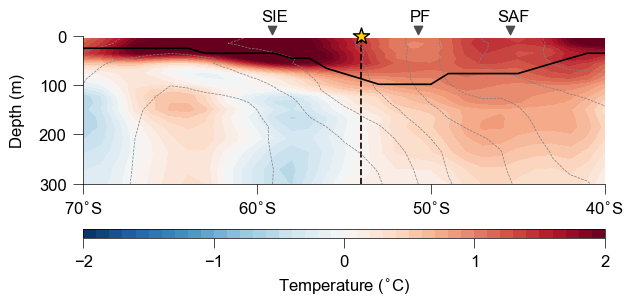

In [17]:
fig,ax = plt.subplots(figsize=(6.5,3.2))

# plot the seasonal temperature range

temp_range = (en4.temperature.sel(time='2019-02-15T00:00:00.000000000', lon=0.0)-273.15) - (en4.temperature.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)-273.15)
salt_range = (en4.salinity.sel(time='2019-02-15T00:00:00.000000000', lon=0.0)-273.15) - (en4.salinity.sel(time='2018-12-16T12:00:00.000000000', lon=0.0)-273.15)

img=ax.contourf(en4.lat, en4.depth, temp_range, levels=np.arange(-2, 2.1, 0.1), cmap='RdBu_r', extend='both')

plt.colorbar(mappable=img, extendfrac=0, ticks=np.arange(-2, 3, 1), orientation='horizontal', aspect=60, pad=0.2, label='Temperature ($^{\circ}$C)', shrink=1)

# set plot limits

ax.set_xlim(-70, -40)
ax.set_ylim(300, 0)

ax.yaxis.set_ticks(np.arange(0, 400, 100))

# plot glider location

ax.axvline(-54, c='k', ls='--')

ax.scatter(-54, 0, s=150, marker='*', c='gold', edgecolor='k', lw=1, zorder=100, clip_on=False)

# contour the density

ax.contour(en4.lat, en4.depth, density, levels=[1026.3, 1026.5, 1026.7, 1026.9, 1027.1, 1027.3, 1027.5, 1027.7, 1027.9], colors='0.5', linewidths=0.5, linestyles='--')

# plot the mld

ax.plot(en4.lat, mld, c='k')

# add some spines to the plot

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True

# change the xlabels

ax.xaxis.set_ticks(np.arange(-70, -30, 10))
ax.xaxis.set_ticklabels(['70$^{\circ}$S', '60$^{\circ}$S', '50$^{\circ}$S', '40$^{\circ}$S'])

ax.set_ylabel('Depth (m)', labelpad=10)

# set a title

# ax.set_title('Temperature range: Dec 2018 - Feb 2019', fontsize=12, pad=25)

# add the location of the sea ice and the fronts

ax.scatter(np.squeeze(sie['si_lat'][sie['si_lon']==0.5]), -12, marker='v', clip_on=False, label='Sea ice extent', c='0.3')

ax.scatter(fronts['pf_lat'][0], -12, marker='v', clip_on=False, label='Polar Front', c='0.3')
ax.scatter(fronts['saf_lat'][0], -12, marker='v', clip_on=False, label='Subantarctic Front', c='0.3')

ax.text(sie['si_lat'][sie['si_lon']==0.5]-0.6, -30, 'SIE', fontsize=12)

ax.text(fronts['pf_lat'][0]-0.5, -30, 'PF', fontsize=12)
ax.text(fronts['saf_lat'][0]-0.75, -30, 'SAF', fontsize=12)

fig.tight_layout()

plt.savefig('../../figs/figure_1c.png', dpi=500)